# **Mushroom Classification - Playground Series**

Initial script.

- EDA
- First Submission

### **Set-up**

In [1]:
setwd("~/Google Drive/My Drive/DS_Projects/Playground_Series/ps4s8_Mushroom_Classification/")
options(scipen = 9999)

In [88]:
# Loading libraries
library(tidyverse)
library(effectsize)
library(naniar)
library(tidymodels)
library(tune)
library(bonsai)
library(embed)
library(finetune)
library(future)
library(vip)
tidymodels_prefer()

In [ ]:
train <- read_csv("Data/train.csv")
test <- read_csv("Data/test.csv")

# Correct column names 
col_names <- colnames(train)
col_names <- gsub("-", "_", col_names)
colnames(train) <- col_names

col_names <- colnames(test)
col_names <- gsub("-", "_", col_names)
colnames(test) <- col_names
features <- train %>% select(-id, -class) %>% colnames()


In [203]:
# To improve visualization of the plots
my_theme <- function() {
  theme_bw() +
  theme(
    text = element_text(size = 20),
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 20),
    legend.text = element_text(size = 18),
    legend.title = element_text(size = 20),
    plot.title = element_text(size = 24),
  )
}

### **Missing Data Exploration**

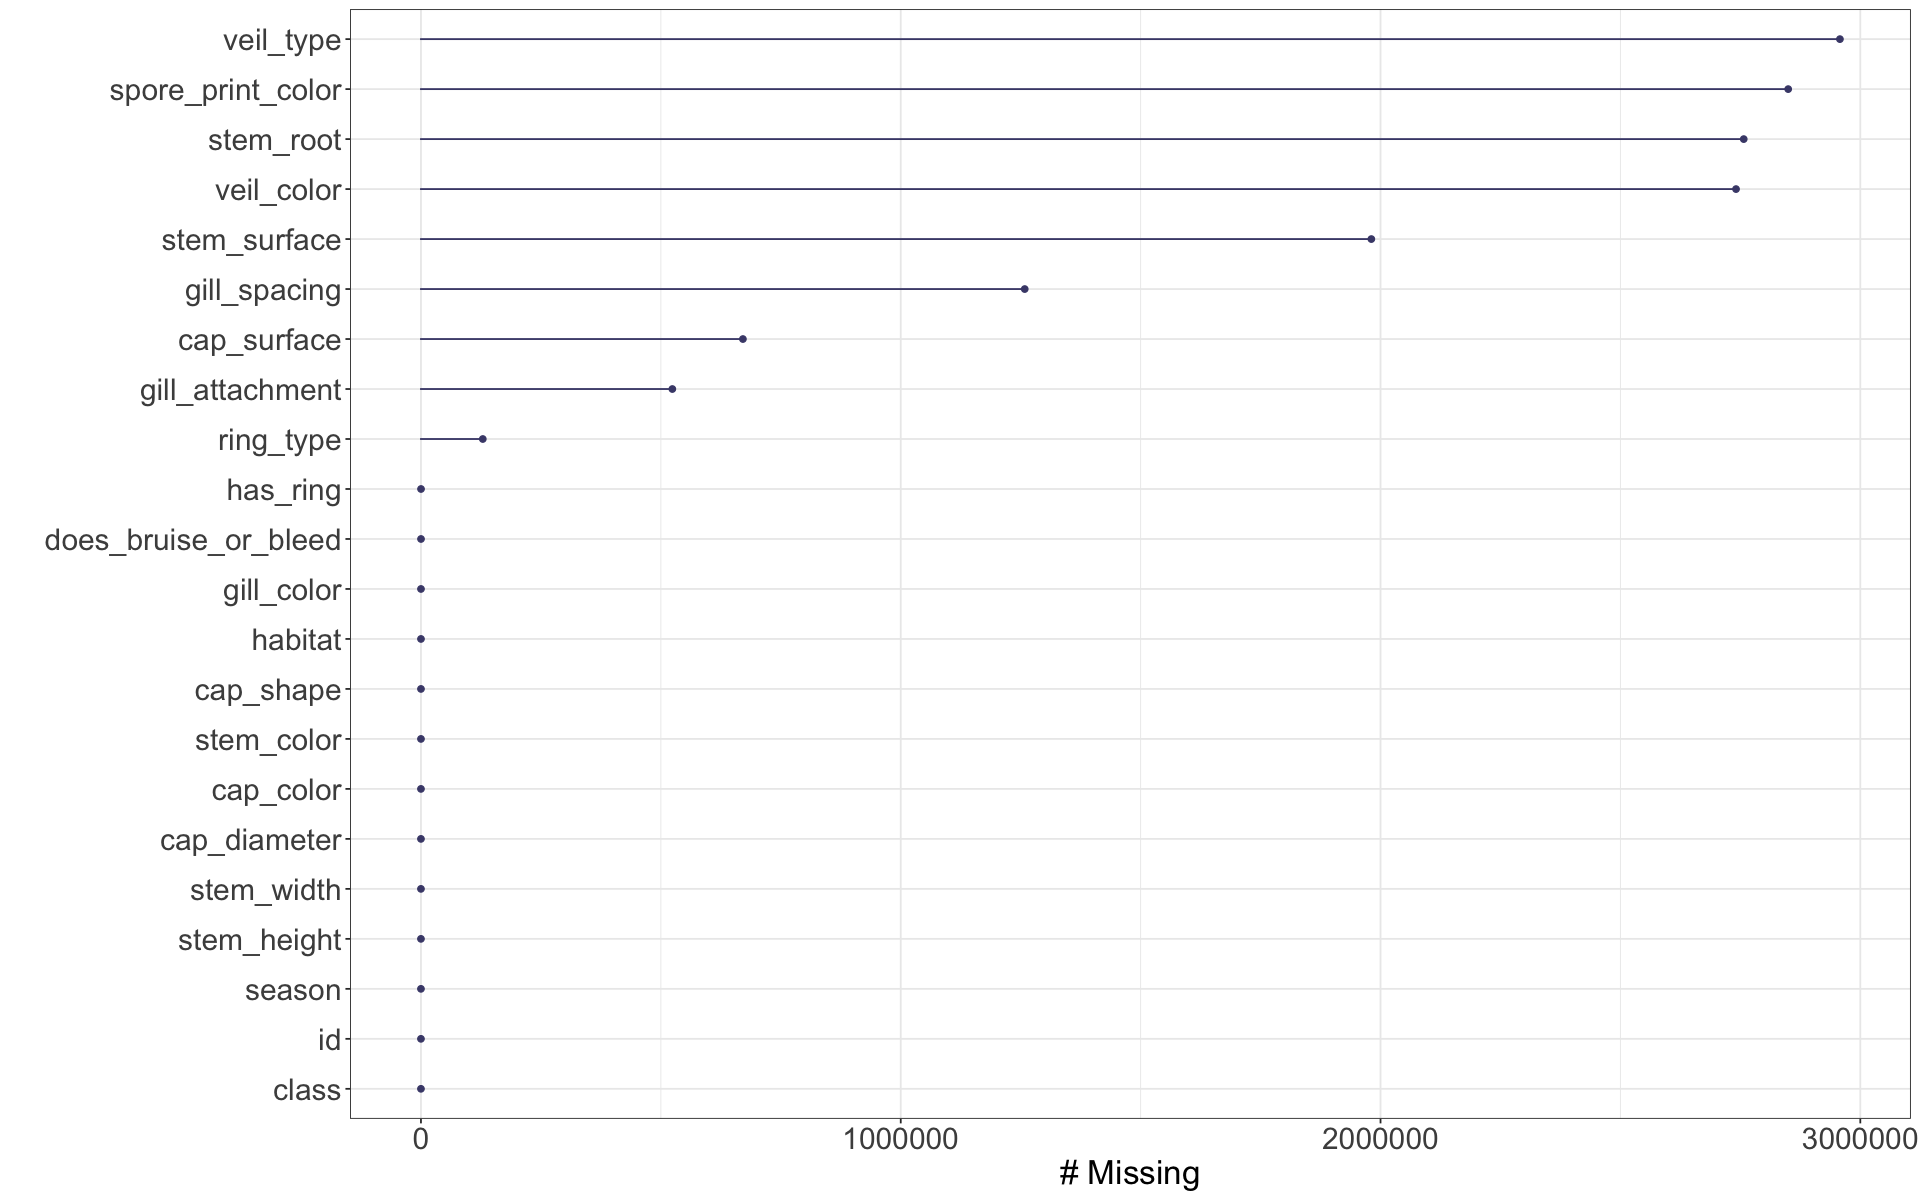

In [462]:
# Lets see missing data with naniar package
gg_miss_var(train) + my_theme() + xlab("")

In [463]:
# Missing data Train
# Columns with over 80% missing are: veil_color, stem_root, spore_print_color, veil_type
train_missing <- train %>% 
  map_df(is.na) %>% 
  map_df(sum) %>% 
  pivot_longer(cols = everything(), names_to = "features", values_to = "na_count") %>%
  mutate(pct = round(na_count/nrow(train),3)) %>% 
  arrange(desc(na_count)) 

test_missing  <- test %>% 
  map_df(is.na) %>% 
  map_df(sum) %>% 
  pivot_longer(cols = everything(), names_to = "features", values_to = "na_count") %>%
  gather(features, na_count) %>% 
  mutate(pct = round(na_count/nrow(test),3)) %>% 
  arrange(desc(na_count)) 

# Proportion of missing data are identical between train and test
train_missing %>% 
  left_join(test_missing, by = "features", suffix = c("_train", "_test")) 

features,na_count_train,pct_train,na_count_test,pct_test
<chr>,<int>,<dbl>,<int>,<dbl>
veil_type,2957493,0.949,1971545,0.949
spore_print_color,2849682,0.914,1899617,0.914
stem_root,2757023,0.885,1838012,0.885
veil_color,2740947,0.879,1826124,0.879
stem_surface,1980861,0.636,1321488,0.636
gill_spacing,1258435,0.404,839595,0.404
cap_surface,671023,0.215,446904,0.215
gill_attachment,523936,0.168,349821,0.168
ring_type,128880,0.041,86195,0.041


In [464]:
# Whats up with veil_type? Almost 95% missing data
train %>% 
  count(veil_type) %>% 
  arrange(desc(n))  %>% 
  left_join(test %>% count(veil_type), by = "veil_type", suffix = c("_train", "_test"))

# Mainly one value, missing could be a category in this case
# This also applies to test

veil_type,n_train,n_test
<chr>,<int>,<int>
NA,2957493,1971545
u,159373,106373
w,11,12
a,9,2
e,8,6
f,8,NA
b,5,1
c,5,2
g,4,3


**Does missing have a pattern?**

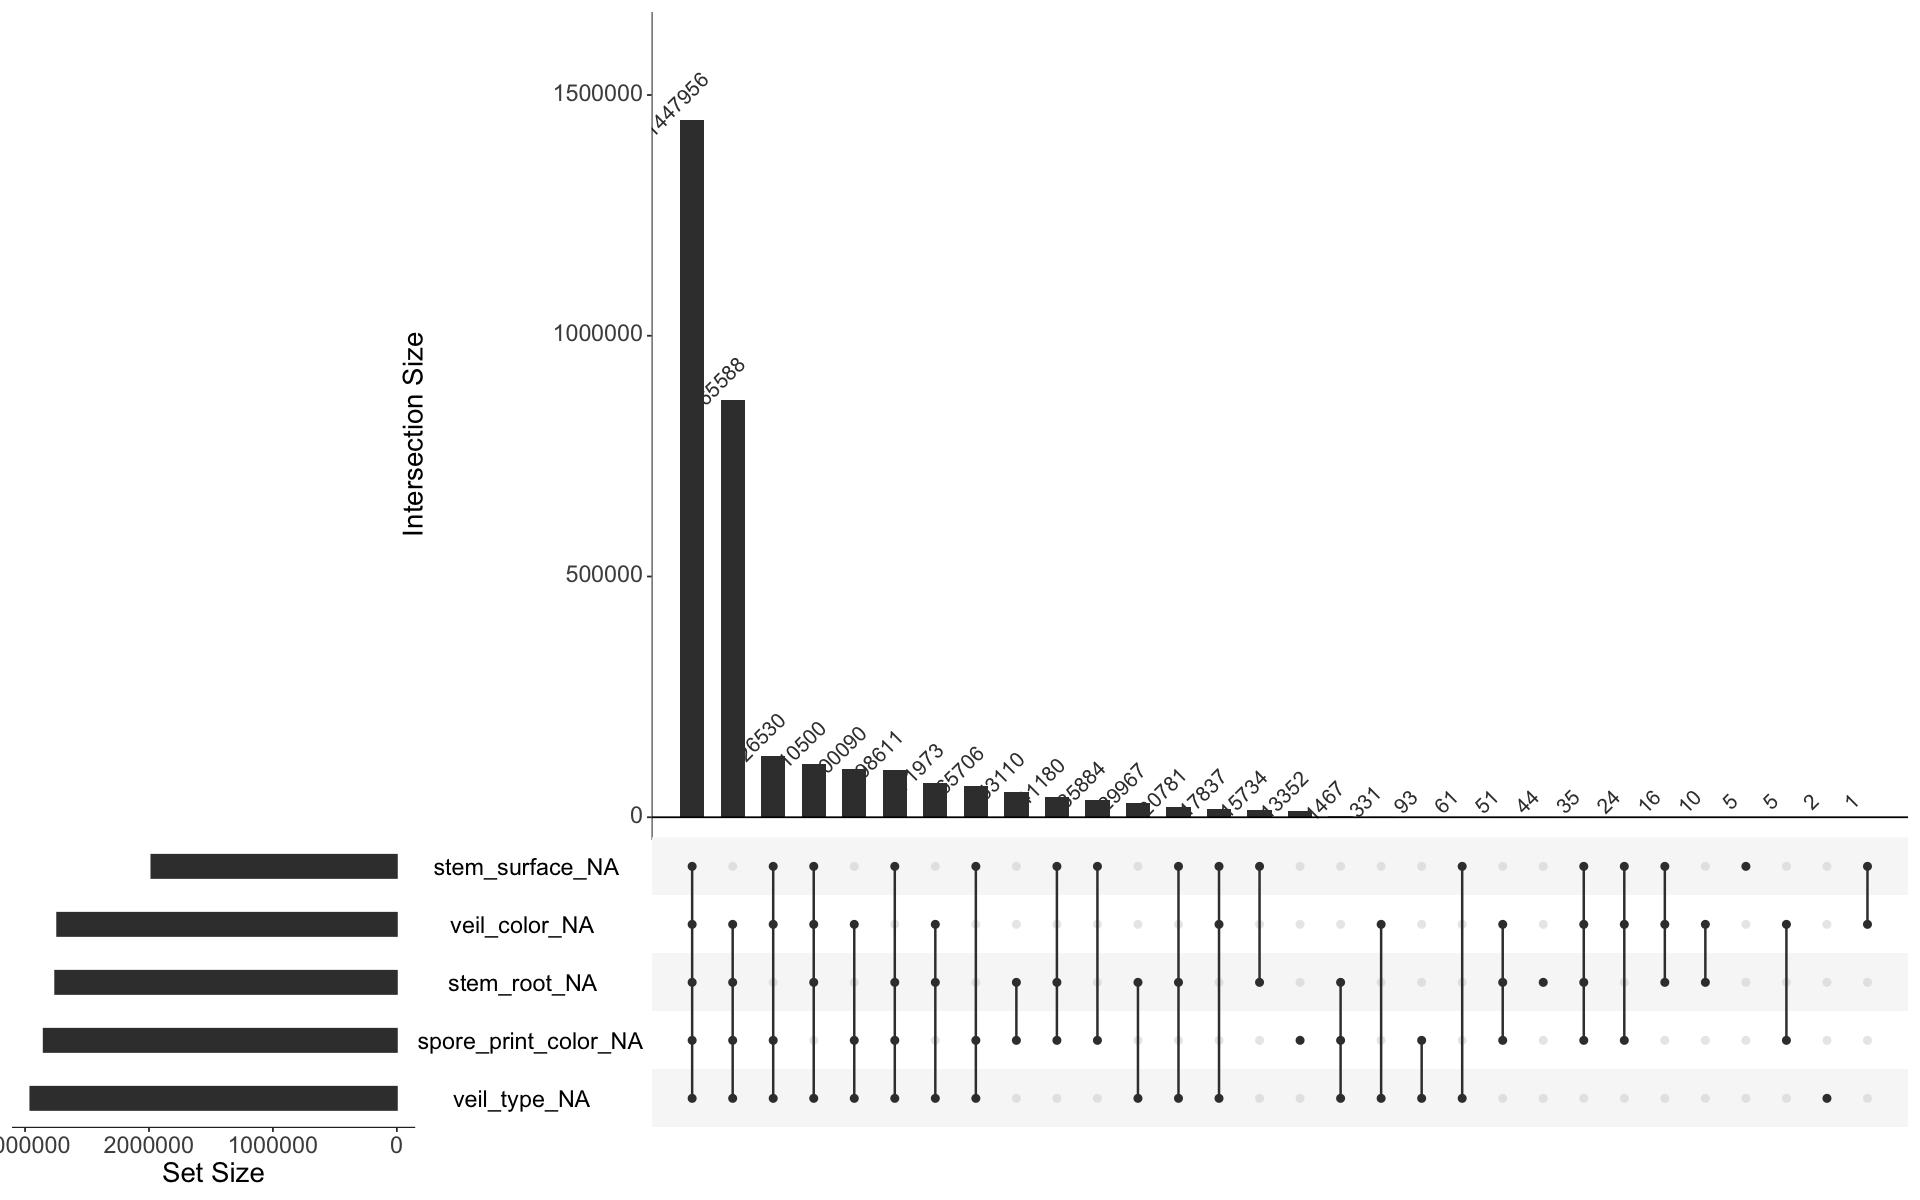

In [465]:
# Lets see an upset plot of train
gg_miss_upset(train, text.scale = 2, number.angles = 45, nsets=5)

**Systematic missingness:**

The high correlation in missingness among the top five variables suggests a systematic reason for this data being absent. It could be due to data collection methods? certain types of mushrooms being harder to classify? or specific study designs.

**Does missing data have any pattern with the Class?**

In [91]:
train_bool <- train %>% 
  mutate_at(vars(all_of(features)), function(x) is.na(x))

relevant_feats_missing <- train_bool %>% 
  select(all_of(features)) %>% 
  summarise_all(sum) %>% 
  pivot_longer(cols = everything(), names_to = "feature", values_to = "is_missing") %>%
  filter(is_missing > 5) %>% pull(feature)

results <- train_bool %>%
  select(id, class, all_of(relevant_feats_missing)) %>%
  gather(features, is_missing, all_of(relevant_feats_missing)) %>%
  group_by(features, is_missing) %>%
  # Calculate the proportion of poisonous mushrooms between missing and non missing values
  summarize(total = n(),
    poisonous = sum(class == "p"),
    prop_poisonous = poisonous / total,
    .groups = "drop")  %>% 
  group_by(features) %>%
  # Calculate the difference in proportion of poisonous mushrooms between missing and non missing values
  mutate(baseline = prop_poisonous[!is_missing], 
    abs_diff_from_baseline = abs(prop_poisonous - baseline)) %>% # absolute difference
  filter(is_missing) %>%  # Keep only the rows where is_missing is TRUE
  ungroup() %>%
  arrange(desc(abs(abs_diff_from_baseline)))  # Sort by absolute difference


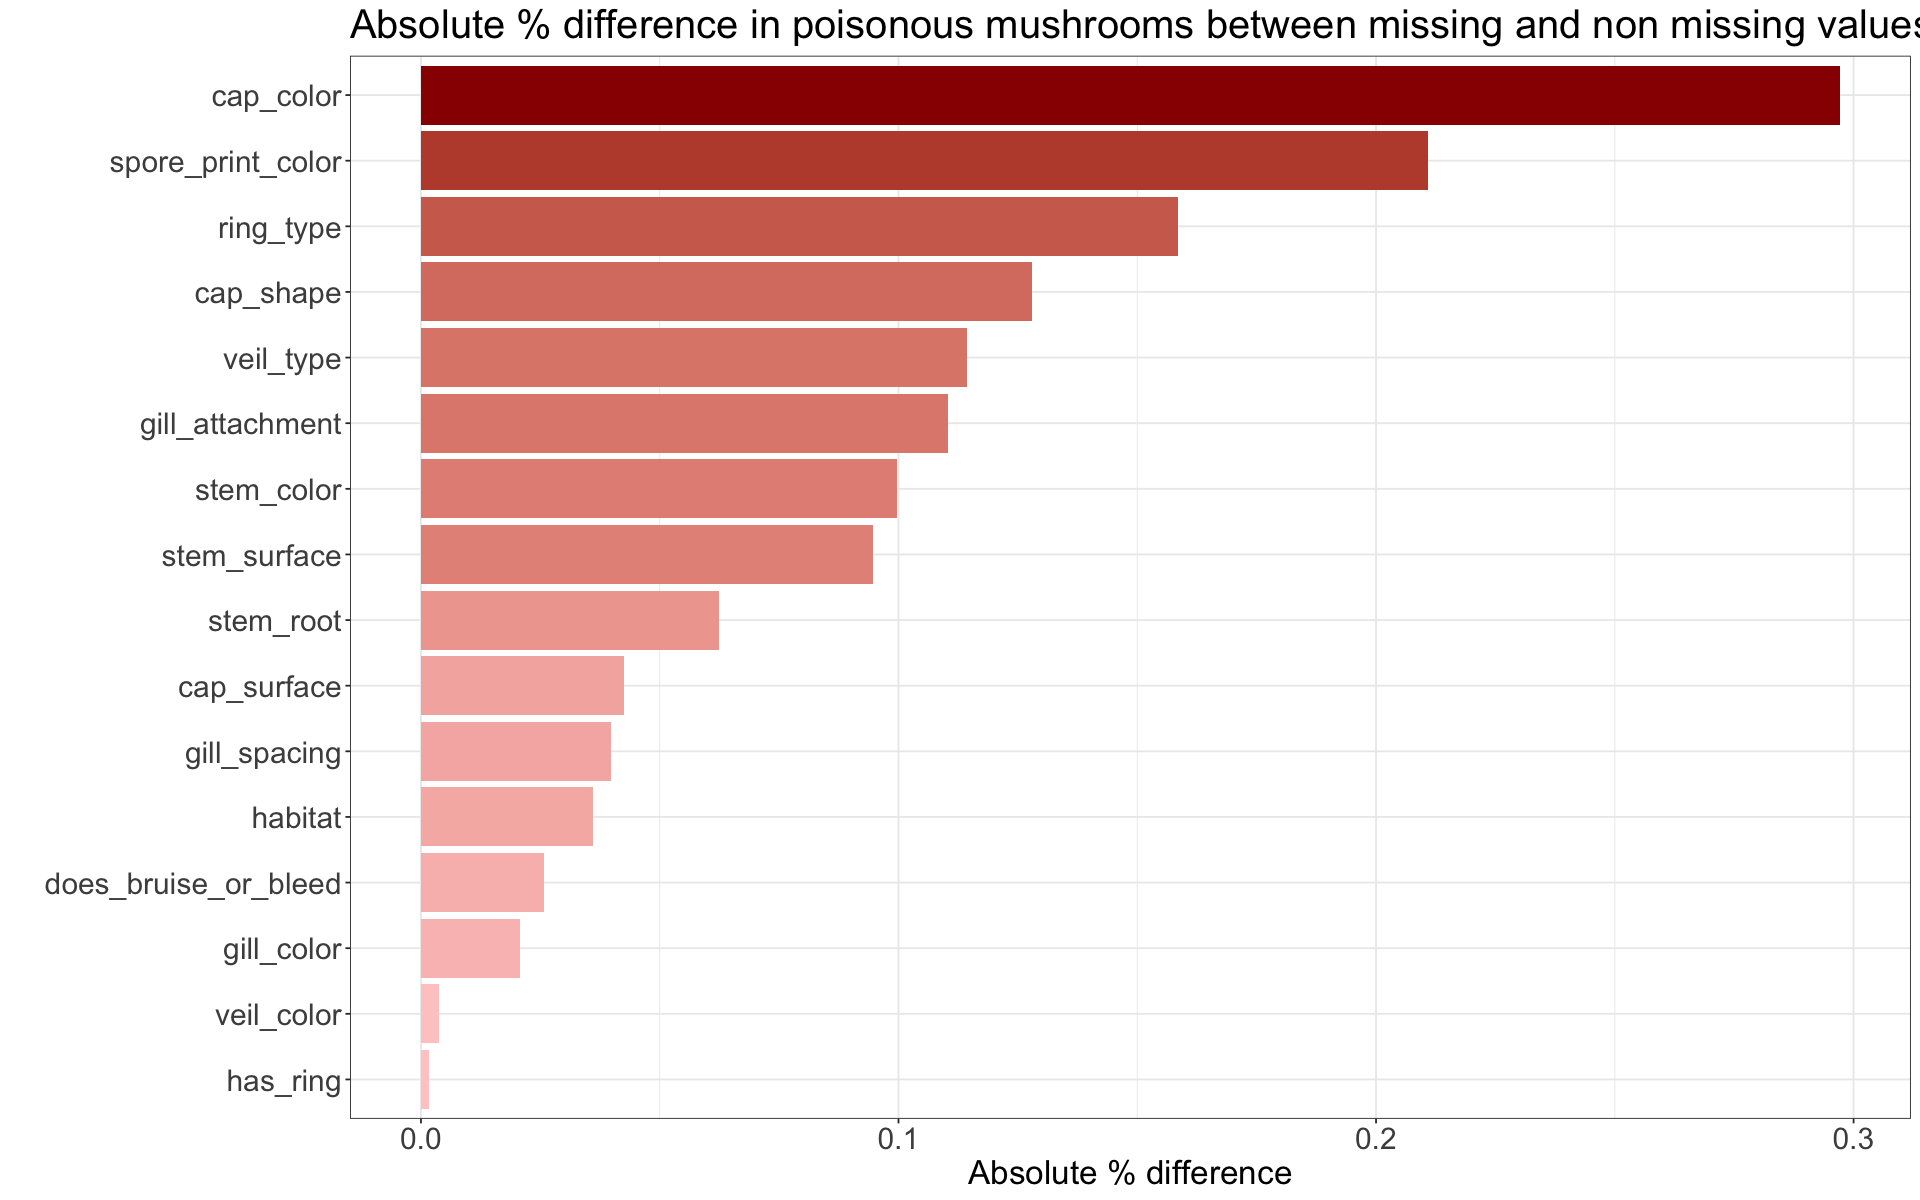

In [92]:
options(repr.plot.width=16, repr.plot.height=10)
results %>% 
  ggplot(aes(x = reorder(features, abs_diff_from_baseline), y = abs_diff_from_baseline, fill = abs_diff_from_baseline)) +
  geom_bar(stat = "identity", position = "dodge") +
  ylab("Absolute % difference") + xlab("") +
  scale_fill_gradient(low = "#FFCCCC", high = "#990000") +
  ggtitle("Absolute % difference in poisonous mushrooms between missing and non missing values") +
  coord_flip() +
  my_theme() +
  theme(legend.position = "none")

Missing data is relevant:

- `cap_color` has almost 30% difference between missing and non missing values. 
- `veil_color`and `has_ring` have barely any difference with respect non missing values. 

This information is relevant when imputing, missing could be category of its own in high missing features. 

### **Distribution of numeric Variables**

In [198]:
num_features <- train %>% 
  select_if(is.numeric) %>% 
  select(-id) %>% colnames()

df_dist <- train %>% 
  select(all_of(num_features)) %>% 
  mutate(type = "train") %>% 
  bind_rows(test %>% # adding test data to compare
              select_if(is.numeric) %>% 
              mutate(type = "test")) %>% 
    pivot_longer(cols = cap_diameter:stem_width, names_to = "features", values_to = "values")

# See distribution
# There is a extreme value in test cap_diameter
df_dist %>% 
  group_by(type, features) %>% 
  summarise(min = min(values, na.rm = TRUE),
            p25 = quantile(values, 0.25, na.rm = TRUE),
            p50 = quantile(values, 0.50, na.rm = TRUE),
            mean = mean(values, na.rm = TRUE),
            p75 = quantile(values, 0.75, na.rm = TRUE),
            max = max(values, na.rm = TRUE)) %>% 
  ungroup() %>% 
  arrange(features)

`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.


type,features,min,p25,p50,mean,p75,max
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
test,cap_diameter,0.00,3.31,5.74,6.306192,8.23,607.00
train,cap_diameter,0.03,3.32,5.75,6.309848,8.24,80.67
test,stem_height,0.00,4.67,5.88,6.346509,7.41,57.29
train,stem_height,0.00,4.67,5.88,6.348333,7.41,88.72
test,stem_width,0.00,4.97,9.64,11.148374,15.62,102.91
train,stem_width,0.00,4.97,9.65,11.153785,15.63,102.90


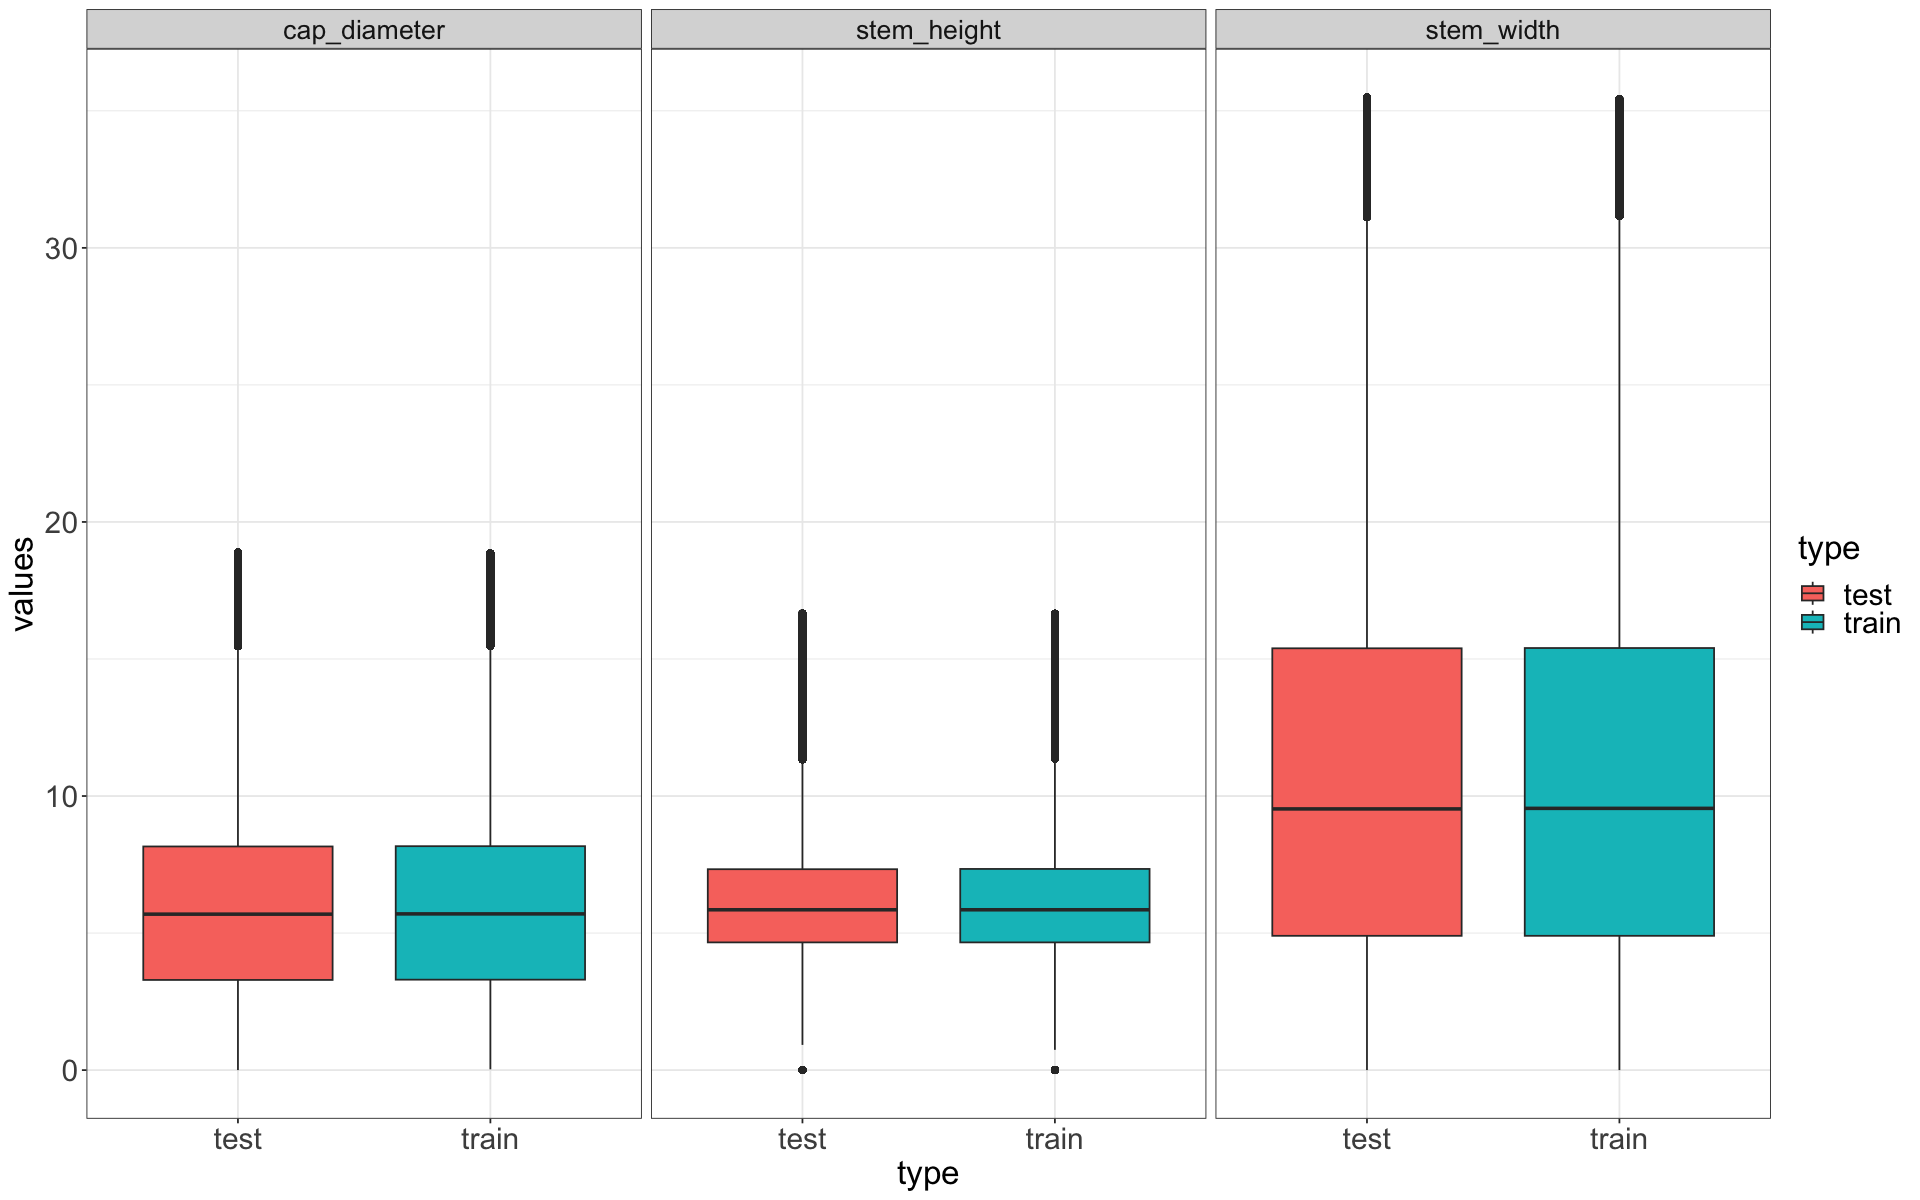

In [103]:
# Train and test distribution of numeric variables are identical
df_dist %>% 
  group_by(type, features) %>% 
  # Remove extreme ouliers
  filter(values < quantile(values, 0.99, na.rm = TRUE)) %>% 
  ungroup() %>% 
  ggplot(aes(x = type, y = values, fill = type)) +
  geom_boxplot() +
  facet_wrap(~features, ncol=3) +
  my_theme()

Main ideas:

- The distribution between train and test set of the numerical variables are identical. 
- The distributions are slightly negatively skewed (to the right).
- The data shows outliers, however `cap_diameter` has a extreme outlier.

### **Categorical Variables Exploration**

There seems to be a lot of values for each categorical features. I will analyze this by counting each value within a feature, and classifying each value into three types:

- Mayority Values that account for the 90% of the Feature.
- Minority that account for almost the 10% remaining.
- Rare that account for les than 0.1% 

In [196]:
cat_features <- train %>% 
  select_if(is.character) %>% 
  select(-class) %>% colnames()

cat_counts <- train %>% # If you want to explot test set change dataset here
  select(all_of(cat_features)) %>% 
  pivot_longer(everything(), names_to = "features", values_to = "values") %>%
  group_by(features, values) %>% 
  summarise(n = n()) %>%
  filter(!is.na(values)) %>% # remove NA values from each feature
  arrange(desc(n)) %>% 
  mutate(pct = n/sum(n),
         cum_pct = cumsum(pct),
         type = case_when(
           pct > 0.05 ~ "Majority",
           between(pct, 0.001, 0.05) ~ "Minority",
           TRUE ~ "Rare"
         ))

`summarise()` has grouped output by 'features'. You can override using the
`.groups` argument.


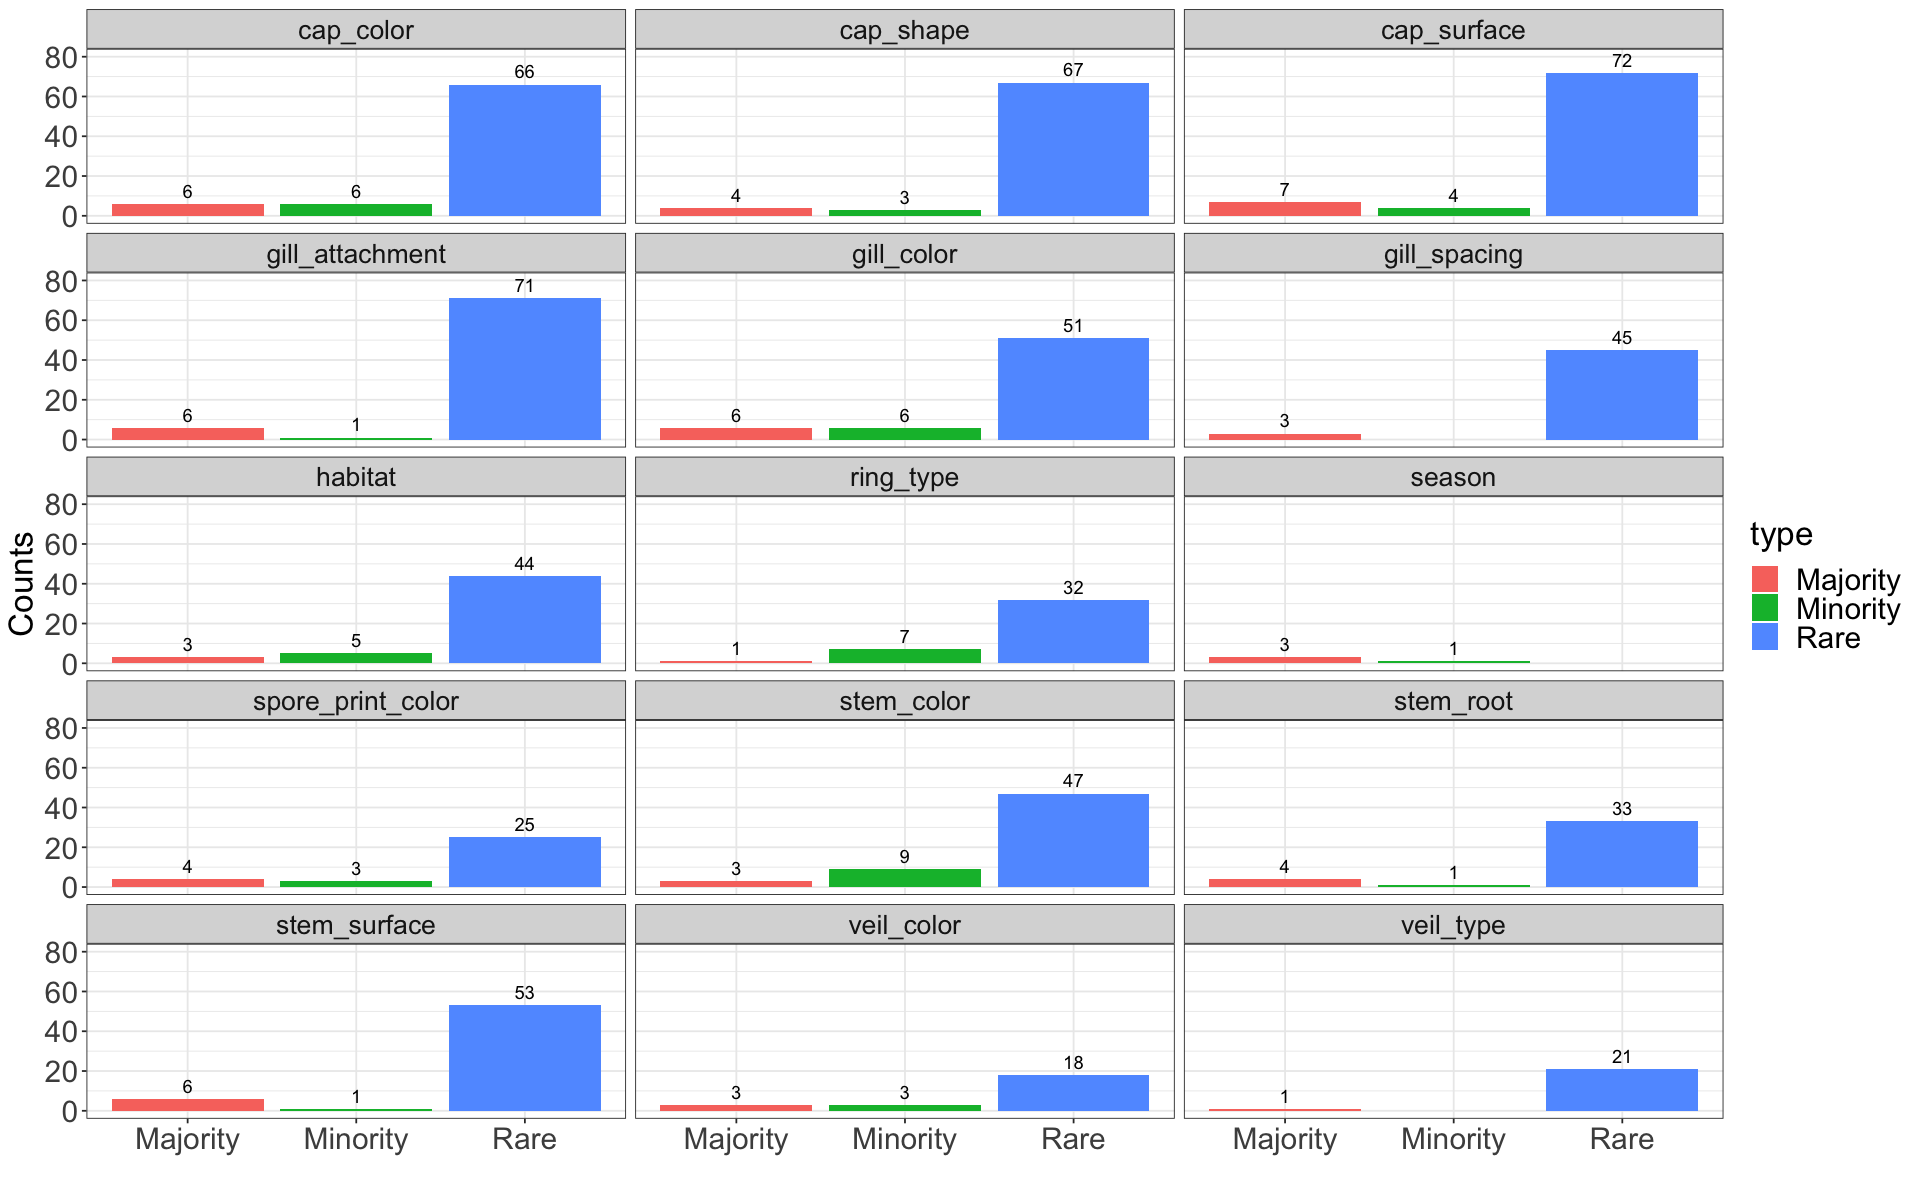

In [197]:
# Lets see all the categorical variables
cat_counts %>% 
  count(features, type) %>% 
  ggplot(aes(x = type, y = n, fill = type)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = n), vjust = -0.5) +
  facet_wrap(~features, ncol = 3) +
  my_theme() + ylim(c(0,80)) +
  xlab("") + ylab("Counts")

In [399]:
# Example of rare values for cap_surface
cat_counts %>% 
    filter(features == "cap_surface" ) # explore other features 

features,values,n,pct,cum_pct,type
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
cap_surface,t,460777,0.1883858111583,0.1883858,Majority
cap_surface,s,384970,0.1573925906059,0.3457784,Majority
cap_surface,y,327826,0.1340296215497,0.4798080,Majority
cap_surface,h,284460,0.1162997021164,0.5961077,Majority
cap_surface,g,263729,0.1078239616799,0.7039317,Majority
cap_surface,d,206832,0.0845619770377,0.7884937,Majority
cap_surface,k,128875,0.0526897423548,0.8411834,Majority
cap_surface,e,119712,0.0489435067839,0.8901269,Minority
cap_surface,i,113440,0.0463792385857,0.9365062,Minority


Important findings:

- `Rare` types make of the mayority of the unique values for almost all of the categorical features.
- `Rare` types usually have less than 100 values. (Check other features above)
- `cap_surface`, `habitat` and `cap_shape` have around 70 unique rare values.
- Many of the rare values in cap_surface is just **garbage or noise**

**Does the original dataset have this rare values?**

In [174]:
# install.packages("ucimlrepo")
library(ucimlrepo)

# Fetch the Mushroom dataset
mushroom_data <- ucimlrepo::fetch_ucirepo(id = 848)
original_data <- mushroom_data$data$original %>% as_tibble() 

# Correct column names 
col_names <- colnames(original_data)
col_names <- gsub("-", "_", col_names)
colnames(original_data) <- col_names

Comparing to the original dataset, most of the unique variables seen in train were just created, the original dataset doesn't have this rare values.

In [179]:
original_data %>% count(cap_surface, sort = TRUE)

cap_surface,n
<chr>,<int>
NaN,14120
t,8196
s,7608
y,6341
h,4974
g,4724
d,4432
e,2584
k,2303


**Is this true for test set?**

In [227]:
train_test_count <- train %>% 
  select(-class) %>%
  mutate(split = "train") %>%
  # adding test set to the mix
  bind_rows(test %>% mutate(split = "test"))  %>% 
  select(all_of(cat_features), split) %>% 
  pivot_longer(cols = -split, names_to = "features", values_to = "values")  %>%
  group_by(split, features, values) %>% 
  summarise(n = n()) %>%
  filter(!is.na(values)) %>% # remove NA values from each feature
  arrange(desc(n)) %>% 
  mutate(pct = n/sum(n),
         type = case_when(
           pct > 0.05 ~ "Majority",
           pct >= 0.001 ~ "Minority",
           TRUE ~ "Rare"
         )) 
  
  train_test_count  %>% 
  count(features, type)  %>% 
  pivot_wider(names_from = features, values_from = n)  %>% 
  arrange(type, split)


`summarise()` has grouped output by 'split', 'features'. You can override using
the `.groups` argument.


split,type,cap_color,cap_shape,cap_surface,gill_attachment,gill_color,gill_spacing,habitat,ring_type,season,spore_print_color,stem_color,stem_root,stem_surface,veil_color,veil_type
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
test,Majority,6,4,7,6,6,3,3,1,3,4,3,4,6,3,1
train,Majority,6,4,7,6,6,3,3,1,3,4,3,4,6,3,1
test,Minority,6,3,4,1,6,NA,5,7,1,3,9,1,1,3,NA
train,Minority,6,3,4,1,6,NA,5,7,1,3,9,1,1,3,NA
test,Rare,45,55,48,59,44,32,31,28,NA,26,43,26,47,17,14
train,Rare,66,67,72,71,51,45,44,32,NA,25,47,33,53,18,21


In [226]:
# Comparing train and test set majority features
train_test_count %>% 
    filter(type == "Minority", # change here to see other types
    features == "habitat") %>% # change here to see other features
    select(split, features, values, pct) %>%
    pivot_wider(names_from = split, values_from = pct) 

features,values,train,test
<chr>,<chr>,<dbl>,<dbl>
habitat,m,0.048435625,0.048730016
habitat,h,0.038543745,0.038515086
habitat,w,0.005945009,0.005930877
habitat,p,0.005511887,0.005500161
habitat,u,0.001688858,0.001652599


For test set:

- The majority features are identical between train and test set (explore above).
- The minority features are identical too.
- The rar features are different (noise)

**Does these rare values have any predictive power?**

Lets calculate chi-square statistic and Cramers'V for feature.

In [358]:
# Step 1: Create encoding function
encode_categories <- function(data) {
  data %>%
    group_by(features, values) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(features) %>%
    mutate(
      total = sum(count),
      prevalence = count / total,
      type = case_when(
        prevalence > 0.05 ~ "Majority",
        prevalence > 0.001 ~ "Minority",
        TRUE ~ "Rare"
      )
    ) %>%
    select(features, values, count, type)
}

# Step 2: Create long dataset in train for categorical variables 
train_long <- train %>% 
    select(class, all_of(cat_features))  %>% 
    pivot_longer(cols = -class, names_to = "features", values_to = "values") %>% 
    filter(!is.na(values)) 

# Step 3: Apply encoding
encoded_categories <- train_long %>%
  encode_categories()

# Step 4: Join encoded categories with original data
encoded_data <- train_long %>%
  left_join(encoded_categories, by = c("features", "values"))

In [315]:
# Identify Features_Types with only 1 categorical variable
# The statistical test to follow can't handle 1 value of a categorical variable
remove_feature_types <- cat_counts %>% 
  count(features, type)  %>% 
  filter(n == 1) %>% 
  unite("features_type", features, type, sep = "_") %>% pull(features_type)

In [353]:
# Step 5: Apply Chi-Square test to identify relationship between categorical variables # nolint
# Cramers V is a measure of association between two categorical variables
# Lowering sample size avoids over-signficance of chi-squared test
set.seed(40)
encoded_data %>%
  unite("features_type", features, type, sep = "_") %>%
  filter(!features_type %in% remove_feature_types) %>% 
  sample_n(5e6) %>% 
  group_by(features_type) %>%
  summarise(
    chi_square = chisq.test(table(values, class))$statistic, # Is there a relationship between the two categorical variables?
    p_value = round(chisq.test(table(values, class))$p.value, 4), # How likely is the relationship due to chance?
    significant = p_value < 0.05,
    cramers_v = cramers_v(table(values, class))$Cramers_v, # How strong is the relationship? 0 to 1
    .groups = "drop") %>%
  mutate(interpretation = case_when(cramers_v < 0.10 ~ "Negligible association",
                                    cramers_v < 0.20 ~ "Weak association",
                                    cramers_v < 0.40 ~ "Moderate association",
                                    cramers_v < 0.60 ~ "Relatively strong association",
                                    cramers_v < 0.80 ~ "Strong association",
                                    cramers_v <= 1.00 ~ "Very strong association",
                                    TRUE ~ "Invalid Cramer's V")) %>%
  arrange(desc(cramers_v))

Warning message:
"There were 30 warnings in `summarise()`.
The first warning was:
i In argument: `chi_square = chisq.test(table(values, class))$statistic`.
i In group 3: `features_type = "cap_color_Rare"`.
Caused by warning in `chisq.test()`:
! Chi-squared approximation may be incorrect
i Run `dplyr::last_dplyr_warnings()` to see the 29 remaining warnings."


features_type,chi_square,p_value,significant,cramers_v,interpretation
<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>
spore_print_color_Minority,3176.10285,0.0000,TRUE,0.97353799,Very strong association
stem_surface_Rare,81.90757,0.0000,TRUE,0.62021377,Strong association
stem_color_Rare,62.61425,0.0000,TRUE,0.57839735,Relatively strong association
stem_root_Majority,17487.24299,0.0000,TRUE,0.52114437,Relatively strong association
cap_color_Minority,16557.34433,0.0000,TRUE,0.47946229,Relatively strong association
ring_type_Minority,20711.94642,0.0000,TRUE,0.47593834,Relatively strong association
veil_color_Majority,10612.43072,0.0000,TRUE,0.41749091,Relatively strong association
habitat_Minority,8908.60535,0.0000,TRUE,0.40061154,Relatively strong association
veil_type_Rare,11.98264,0.2143,FALSE,0.38968173,Moderate association


Main ideas:

- Most of the groupings by feature are relevant by chi-squared statistic, however this is expected due to the large sample size. 
- Cramers'V comes to the rescue which focuses on the effect size, some of the rare groupings are signficant and have strong association.
- Some rare groupings relevant to notice are `stem_color_Rare`, `stem_surface_Rare`, `veil_color_Rare`.
- The rest of the rare grouping are not significant or relevant from cramers'V View. 

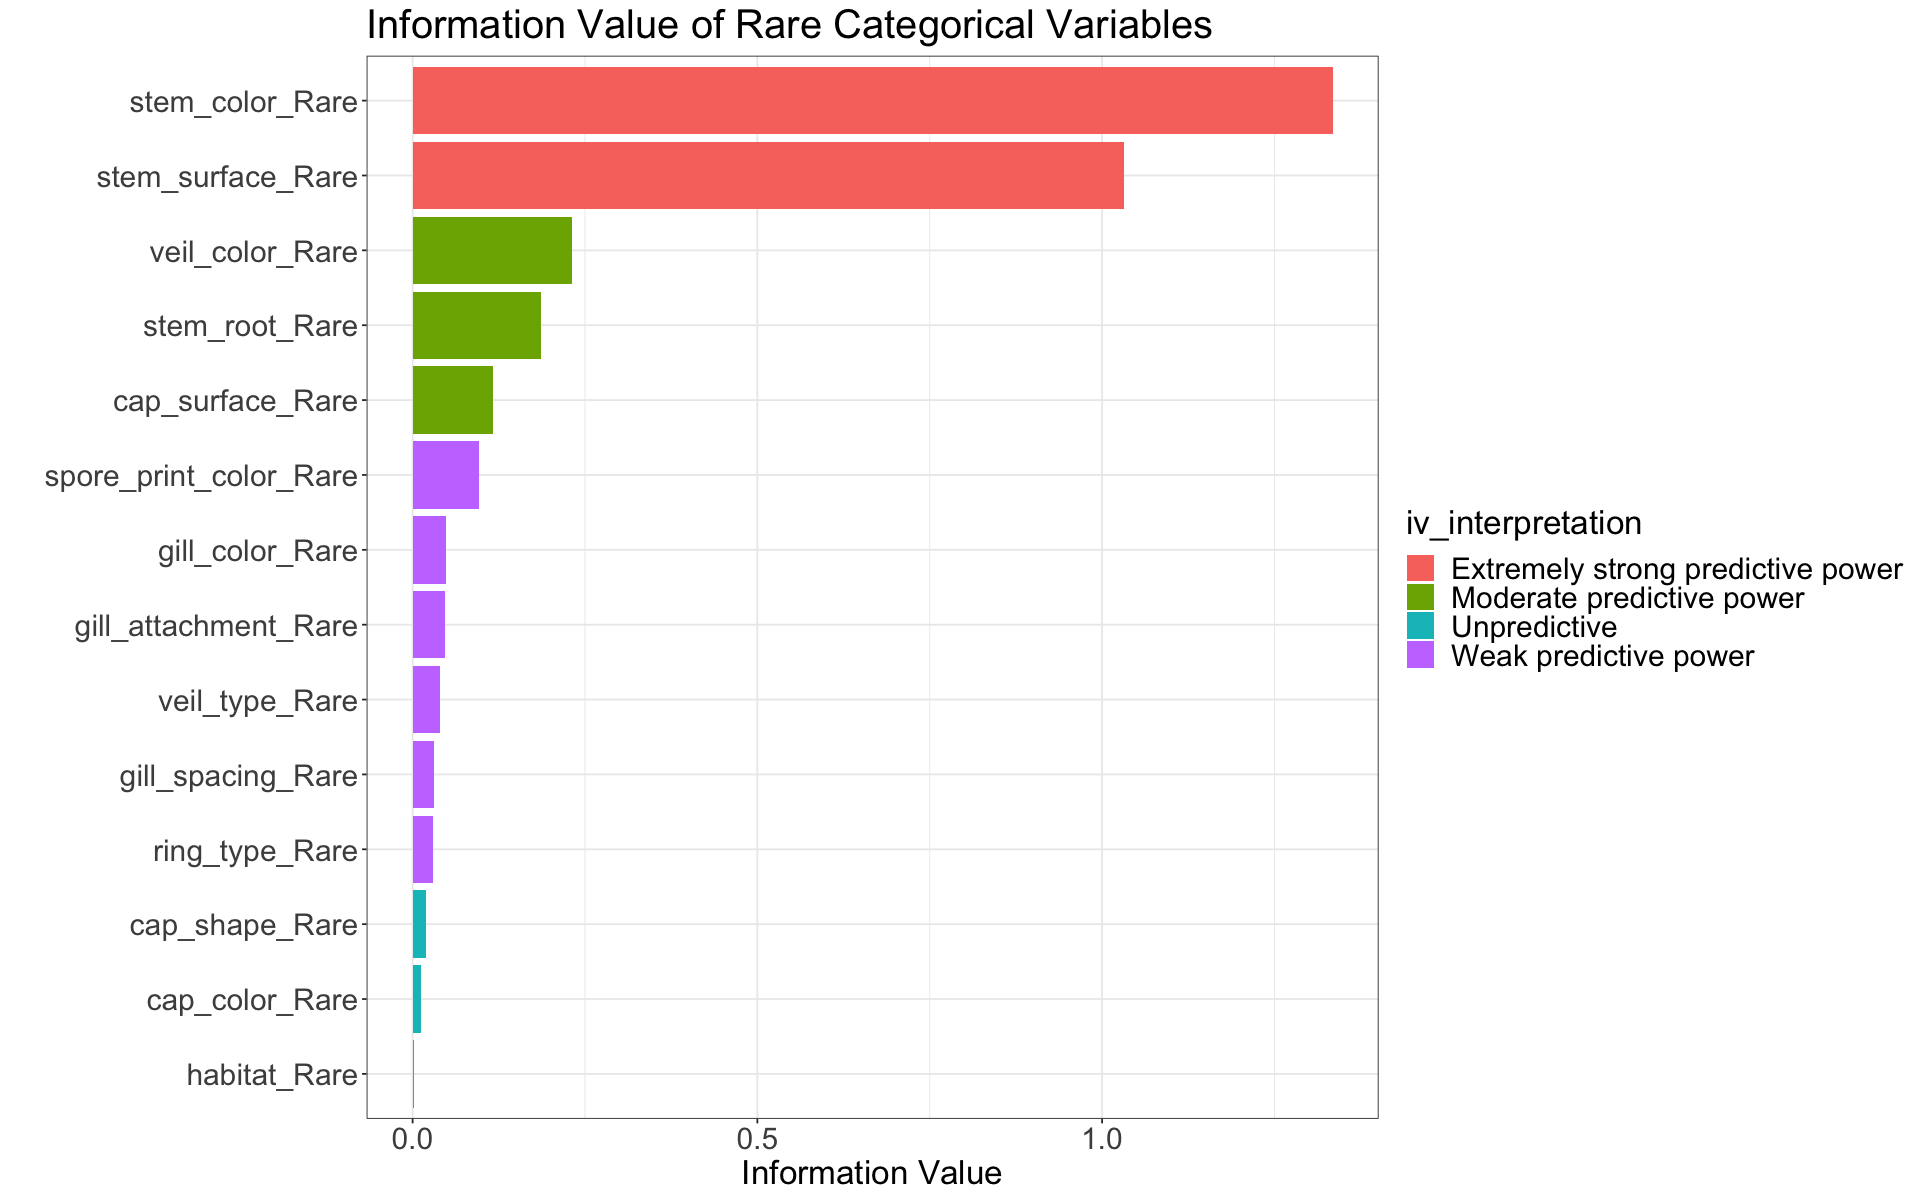

In [418]:
# Lets check with information value and weight of evidence
iv_data <- encoded_data %>%
    filter(type == "Rare") %>%
    unite("features_type", features, type, sep = "_")  %>% 
    count(features_type, class)  %>% 
    pivot_wider(names_from = class, values_from = n)   %>% 
    mutate(prop_p = p / (p + e), # proportion of poisonous mushrooms
           prop_e = e / (p + e), # proportion of edible mushrooms
           woe = log(prop_e / prop_p), # weight of evidence
           inf_value = (prop_e - prop_p) * woe)  %>% # information value
    arrange(desc(inf_value))  %>% 
    mutate(iv_interpretation = case_when(inf_value < 0.02 ~ "Unpredictive",
                                          inf_value < 0.1 ~ "Weak predictive power",
                                          inf_value < 0.3 ~ "Moderate predictive power",
                                          inf_value < 0.5 ~ "Strong predictive power",
                                          inf_value >= 0.5 ~ "Extremely strong predictive power",
                                          TRUE ~ "Suspicious (potential overfitting)"))

iv_data %>% 
       ggplot(aes(x = reorder(features_type, inf_value), y = inf_value, fill = iv_interpretation)) +
       geom_bar(stat = "identity") +
       coord_flip() +
       xlab("") + ylab("Information Value") +
       ggtitle("Information Value of Rare Categorical Variables") +
       my_theme() 

Information value on the rare groupings confirm what we did above that `stem_color_Rare`, `stem_surface_Rare`, `veil_color_Rare` are relevant to the problem. So in the end its **not recommendable to through away rare values at least for these features.**

**Does test set have the same rare types?**

In [406]:
# Rare types are different between train and test set
train %>% 
  count(stem_color) %>% 
  arrange(desc(n)) %>% 
  full_join(test %>% count(stem_color), by = "stem_color") 

stem_color,n.x,n.y
<chr>,<int>,<int>
w,1196637,797365
n,1003464,668156
y,373971,250141
g,132019,88202
o,111541,75094
e,103373,68804
u,67017,44784
p,54690,36356
k,33676,22176


# **Collapsing categorical variables**

I will collapse rare values to a placeholder called `rare` as I did above using a prevalence of 0.1%, this criteria will apply for test set too. 

In [4]:
cat_features <- train %>% 
  select_if(is.character) %>% 
  select(-class) %>% colnames()

# Step 1: Create a function to identify rare categories
identify_rare_categories <- function(data, feature, threshold = 0.001) {
  data %>%
    count(!!sym(feature)) %>%
    mutate(
      total = sum(n),
      prevalence = n / total) %>%
    filter(prevalence >= threshold) %>%
    pull(!!sym(feature))
}

# Step 2: Create a function to replace rare categories with "rare"
replace_rare_categories <- function(data, feature, threshold = 0.001) {
  non_rare <- identify_rare_categories(data, feature, threshold)
  data %>%
    mutate(!!sym(feature) := if_else(!!sym(feature) %in% non_rare, 
                                     !!sym(feature), 
                                     "rare"))
}

# Step 3: Apply the transformation to all categorical variables in the training set
# The reduce function in Step 3 Applies the replace_rare_categories function to each categorical feature in turn
# The result is a dataset where all rare categories (prevalence < 0.001) in all categorical variables have been replaced with "Rare"
train_collapsed <- cat_features %>%
  reduce(function(data, feature) replace_rare_categories(data, feature), .init = train)

# Step 4: Apply the transformation to all categorical variables in the test set
test_collapsed <- cat_features %>%
  reduce(function(data, feature) replace_rare_categories(data, feature), .init = test)

# Lets check if the rare values are now "rare"
train_collapsed %>% 
  count(stem_color) %>% 
  arrange(desc(n)) %>% 
  full_join(test_collapsed %>% count(stem_color), by = "stem_color")

stem_color,n.x,n.y
<chr>,<int>,<int>
w,1196637,797365
n,1003464,668156
y,373971,250141
g,132019,88202
o,111541,75094
e,103373,68804
u,67017,44784
p,54690,36356
k,33676,22176


# **Imputing missing values**

In this first submission I will just create a `Missing` category for categorical variables and for numerical variables impute the median. For logical columns will convert them to integer. 

In [5]:
impute_missing <- function(data) {
  # Identify numeric and categorical columns
  num_cols <- data %>% select_if(is.numeric) %>% names()
  cat_cols <- data %>% select_if(is.character) %>% names()
  
  # Calculate median for numeric columns
  medians <- data %>% summarise(across(all_of(num_cols), ~median(.x, na.rm = TRUE)))
  
  # Impute missing values
  data %>%
    mutate(across(all_of(num_cols), ~replace_na(.x, medians[[cur_column()]]))) %>%
    mutate(across(all_of(cat_cols), ~replace_na(.x, "Missing")))
}

# Apply to train data
train_imputed <- train_collapsed %>% 
  mutate_if(is.logical, as.integer) %>%
  impute_missing()

# Apply to test data
test_imputed <- test_collapsed %>% 
  mutate_if(is.logical, as.integer) %>%
  impute_missing()

In [6]:
# Example of veil type for train and test 
train_imputed %>% 
    count(veil_type) %>% 
    left_join(test_imputed %>% count(veil_type), by = "veil_type", suffix = c("_train", "_test"))

veil_type,n_train,n_test
<chr>,<int>,<int>
Missing,2957493,1971545
rare,79,46
u,159373,106373


# **Tunning with TidyModels**

In [7]:
# Lets start by preparing the target as passing characters as factors
train_ready <- train_imputed %>% 
  mutate(class = as.factor(as.integer(class == 'p'))) %>%
  mutate_if(is.character, as.factor) 

test_ready <- test_imputed %>% 
  mutate_if(is.character, as.factor)

write_csv(train_ready, "Data/train_ready_1s.csv")
write_csv(test_ready, "Data/test_ready_1s.csv")

In [8]:
# 1. Split the data
data_split <- initial_split(train_ready, prop = 0.7)
train_data <- training(data_split)
val_data <- testing(data_split)

In [9]:
# 2. Define two different recipes
recipe_no_encoding <- recipe(class ~ ., data = train_data) %>%
  step_rm(id) %>%
  step_YeoJohnson(all_numeric_predictors())%>%
  step_novel(all_nominal_predictors())%>%
  step_zv()

recipe_effect_encoding <- recipe(class ~ ., data = train_data) %>%
  step_rm(id) %>%
  step_YeoJohnson(all_numeric_predictors())%>%
  step_novel(all_nominal_predictors())%>%
  step_lencode_mixed(all_nominal_predictors(), outcome = vars(class)) %>% 
  step_zv()


In [10]:
# 3. Define the LightGBM model with tunable parameters
lightgbm_model_tune <- boost_tree(
  trees = tune(),
  tree_depth = tune(),
  min_n = tune(),
  sample_size = tune(),
  mtry = tune(),
  learn_rate = tune()
) %>%
  set_engine("lightgbm",
            is_unbalance = TRUE,
            early_stop = 50) %>%
  set_mode("classification")


In [11]:
# 4. Create a workflow set
workflow_exp <- workflow_set(
  preproc = list(no_encoding = recipe_no_encoding, effect_encoding = recipe_effect_encoding),
  models = list(lightgbm = lightgbm_model_tune),
  cross = FALSE
)

In [12]:
# 5. Define the resampling method
cv_folds <- vfold_cv(train_data, v = 5, strata = class)

# 6. Define metrics
metrics <- metric_set(mcc)


In [13]:
# 7. Define the parameter space
lgb_params <- parameters(
  trees(range = c(300, 2000)),
  tree_depth(range = c(3, 8)),
  learn_rate(range = c(-4, -1), trans = log10_trans()),
  min_n(range = c(30, 1000)),
  sample_size = sample_prop(range = c(0.4, 1)),
  mtry(range = c(5,21))
)

In [14]:
# 8. Set up Bayesian optimization
bo_ctrl <- control_bayes(
  no_improve = 20,
  time_limit = 3600,
  verbose = TRUE,
  verbose_iter = TRUE
)

In [15]:
# 9. Set parallel processing
plan(multisession, workers = 8)
options(future.globals.maxSize = 16.0 * 1e9) # 16GB available

In [16]:
# 10. Tune the workflows using Bayesian optimization
tuned_workflows <- workflow_exp %>%
  workflow_map(
    fn = "tune_bayes",
    resamples = cv_folds,
    iter = 100,  # Increased due to more parameters
    initial = 10,  # Increased due to more parameters
    metrics = metrics,
    control = bo_ctrl,
    param_info = lgb_params
  )




>  Generating a set of 10 initial parameter results

v Initialization complete



Optimizing mcc using the expected improvement



-- Iteration 1 -----------------------------------------------------------------



i Current best:		mcc=0.9841 (@iter 0)

i Gaussian process model

! For the mcc estimates, 1 missing value was found and removed before fitting
  the Gaussian process model.

v Gaussian process model

i Generating 5000 candidates

i Predicted candidates

i trees=1935, tree_depth=5, learn_rate=0.033, min_n=641, sample_size=0.41,
  mtry=17

i Estimating performance

i Fold1: preprocessor 1/1

v Fold1: preprocessor 1/1

i Fold1: preprocessor 1/1, model 1/1

v Fold1: preprocessor 1/1, model 1/1

i Fold1: preprocessor 1/1, model 1/1 (extracts)

i Fold1: preprocessor 1/1, model 1/1 (predictions)

i Fold2: preprocessor 1/1

v Fold2: preprocessor 1/1

i Fold2: preprocessor 1/1, model 1/1

v Fold2: preprocessor 1/1, model 1/1

i Fold2: preprocessor 1/1, model 1/1 (extracts)

i Fold2

# **Selecting best Models**

In [23]:
# Extract top 3 models for each recipe
top_3_per_recipe <- tuned_workflows %>%
  rank_results(rank_metric = "mcc") %>%
  filter(.metric == "mcc") %>%
  select(wflow_id, .config, mcc = mean, std_err, n) %>%
  group_by(wflow_id) %>%
  slice_head(n = 3) %>%
  ungroup()
top_3_per_recipe

wflow_id,.config,mcc,std_err,n
<chr>,<chr>,<dbl>,<dbl>,<int>
effect_encoding_lightgbm,Iter21,0.9840568,0.00009355817,5
effect_encoding_lightgbm,Iter29,0.9839987,0.00011278406,5
effect_encoding_lightgbm,Iter40,0.9839712,0.00010717750,5
no_encoding_lightgbm,Iter38,0.9846180,0.00008156351,5
no_encoding_lightgbm,Iter43,0.9846180,0.00008819349,5
no_encoding_lightgbm,Iter32,0.9846021,0.00009684922,5


In [191]:
# Top 3 models no_encoding parameters
tuned_workflows %>%
  extract_workflow_set_result("no_encoding_lightgbm") %>%
  show_best(metric = "mcc", n = 3)

# Top 3 models effect_encoding parameters
tuned_workflows %>%
  extract_workflow_set_result("effect_encoding_lightgbm") %>%
  show_best(metric = "mcc", n = 3)

trees,tree_depth,learn_rate,min_n,sample_size,mtry,.metric,.estimator,mean,n,std_err,.config,.iter
<int>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
1708,8,0.05200064,361,0.7986716,7,mcc,binary,0.9846180,5,0.00008156351,Iter38,38
1735,6,0.07287707,653,0.6950134,8,mcc,binary,0.9846180,5,0.00008819349,Iter43,43
1994,8,0.05618764,944,0.8225854,11,mcc,binary,0.9846021,5,0.00009684922,Iter32,32


trees,tree_depth,learn_rate,min_n,sample_size,mtry,.metric,.estimator,mean,n,std_err,.config,.iter
<int>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
1803,8,0.09648281,981,0.5338327,7,mcc,binary,0.9840568,5,0.00009355817,Iter21,21
1621,8,0.09984316,623,0.6430814,7,mcc,binary,0.9839987,5,0.00011278406,Iter29,29
1925,6,0.07325150,493,0.6084345,7,mcc,binary,0.9839712,5,0.00010717750,Iter40,40


In [83]:
# Extracting workflows and training on all train_data
fitted_no_encoding_models <- tuned_workflows %>%
  extract_workflow_set_result("no_encoding_lightgbm") %>%
  show_best(metric = "mcc", n = 3) %>% 
  select(trees:mtry, .config) %>% 
  group_split(row_number())  %>% # split into rows 
  map(function(x) {
    tuned_workflows %>%
      extract_workflow("no_encoding_lightgbm") %>%
      finalize_workflow(x) %>% 
      fit(data = train_data)
  })

In [ ]:
fitted_effect_encoding_models <- tuned_workflows %>%
  extract_workflow_set_result("effect_encoding_lightgbm") %>%
  show_best(metric = "mcc", n = 3) %>% 
  select(trees:mtry, .config) %>% 
  group_split(row_number())  %>% # split into rows 
  map(function(x) {
    tuned_workflows %>%
      extract_workflow("effect_encoding_lightgbm") %>%
      finalize_workflow(x) %>% 
      fit(data = train_data)
  })

In [115]:
# Evaluating final models on Validation Set
predictions_df <- val_data %>% 
    select(id, class) %>% 
    bind_cols("no_encode1_preds" = predict(fitted_no_encoding_models[[1]], val_data, type = "prob")$.pred_1) %>% 
    bind_cols("no_encode2_preds" = predict(fitted_no_encoding_models[[2]], val_data, type = "prob")$.pred_1) %>%
    bind_cols("no_encode3_preds" = predict(fitted_no_encoding_models[[3]], val_data, type = "prob")$.pred_1) %>% 
    bind_cols("eff_encode1_preds" = predict(fitted_effect_encoding_models[[1]], val_data, type = "prob")$.pred_1) %>% 
    bind_cols("eff_encode2_preds" = predict(fitted_effect_encoding_models[[2]], val_data, type = "prob")$.pred_1) %>%
    bind_cols("eff_encode3_preds" = predict(fitted_effect_encoding_models[[3]], val_data, type = "prob")$.pred_1) %>% 
    as_tibble()

# Lets see the prediction dataframe
predictions_df %>% head(10)

id,class,no_encode1_preds,no_encode2_preds,no_encode3_preds,eff_encode1_preds,eff_encode2_preds,eff_encode3_preds
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.001656451,0.001447542,0.001405761,0.001654525,0.001300399,0.001703432
5,1,0.995752660,0.996950644,0.997771112,0.997074162,0.997794131,0.995664829
7,1,0.995228492,0.997441405,0.996571760,0.997144326,0.998308007,0.997727015
8,1,0.996600868,0.996608704,0.996365077,0.996280176,0.996735922,0.995977245
11,0,0.006836917,0.005151005,0.005493615,0.005856901,0.005783141,0.005190940
12,0,0.005753877,0.003787311,0.006167447,0.004488338,0.006798111,0.005773452
15,1,0.991201679,0.994213121,0.994375479,0.998083955,0.995949015,0.994258650
25,0,0.006809025,0.008954248,0.010959814,0.006980945,0.005291564,0.006623251
29,1,0.997578331,0.997852618,0.998146861,0.998708568,0.998849414,0.998236489


I am going try ensembling from bothe recipes to see if there is any gain.

In [181]:
# Lets generate ensembles of models from the two recipes
# Function to standardize probabilities
standardize_normalize_probs <- function(probs) {
  standardized <- (probs - mean(probs)) / sd(probs)
  normalized <- (standardized - min(standardized)) / (max(standardized) - min(standardized))
  return(normalized)
}

# Ensemble pair of no_encode and eff_encode
predictions_df <- predictions_df %>% 
  mutate_at(vars(ends_with("preds")), standardize_normalize_probs) %>% 
  mutate(ensemble_11_preds = rowMeans(across(c(no_encode1_preds, eff_encode1_preds))),
          ensemble_12_preds = rowMeans(across(c(no_encode1_preds, eff_encode2_preds))),
          ensemble_13_preds = rowMeans(across(c(no_encode1_preds, eff_encode3_preds))),
          ensemble_21_preds = rowMeans(across(c(no_encode2_preds, eff_encode1_preds))),
          ensemble_22_preds = rowMeans(across(c(no_encode2_preds, eff_encode2_preds))),
          ensemble_23_preds = rowMeans(across(c(no_encode2_preds, eff_encode3_preds))),
          ensemble_31_preds = rowMeans(across(c(no_encode3_preds, eff_encode1_preds))),
          ensemble_32_preds = rowMeans(across(c(no_encode3_preds, eff_encode2_preds))),
          ensemble_33_preds = rowMeans(across(c(no_encode3_preds, eff_encode3_preds)))
          )


In [182]:
# Lets calculate the best threshold for each model
optimize_mcc_threshold <- function(truth, probability, step_size = 0.01) {
  # Create a dataframe with truth and probability
  df <- tibble(truth = truth, probability = probability)

  # Function to calculate MCC for a given threshold
  calc_mcc <- function(threshold) {
    predictions <- as.factor(if_else(df$probability >= threshold, 1, 0))
    mcc_vec(df$truth, predictions)
  }
  
  # Generate thresholds
  thresholds <- seq(0.1, 0.9, by = step_size)
  
  # Calculate MCC for each threshold
  mcc_values <- map_dbl(thresholds, calc_mcc)
  
  # Find the threshold that maximizes MCC
  best_threshold <- thresholds[which.max(mcc_values)]
  best_mcc <- max(mcc_values)
  
  # Return results
  list(
    best_threshold = best_threshold,
    best_mcc = best_mcc,
    mcc_curve = tibble(threshold = thresholds, mcc = mcc_values)
  )
}

# Function to apply optimal threshold and calculate metrics
evaluate_with_optimal_threshold <- function(truth, probability) {
  opt_result <- optimize_mcc_threshold(truth, probability)
  predictions <- as.factor(if_else(probability >= opt_result$best_threshold, 1, 0))
  
  tibble(
    optimal_threshold = opt_result$best_threshold,
    f1_score = f_meas_vec(truth, predictions),
    mcc = mcc_vec(truth, predictions),
    roc_auc = roc_auc_vec(truth, probability, event_level = "second")
  )
}


results <- predictions_df %>%
  select(-id, -class) %>%
  imap_dfr(~ evaluate_with_optimal_threshold(val_data$class, .x) %>%
             mutate(model = .y))
results %>% arrange(desc(mcc))

optimal_threshold,f1_score,mcc,roc_auc,model
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.46,0.9914804,0.9844160,0.9972204,no_encode2_preds
0.47,0.9914775,0.9844100,0.9972449,no_encode3_preds
0.46,0.9914498,0.9843599,0.9972443,ensemble_22
0.46,0.9914498,0.9843599,0.9972443,ensemble_22_preds
0.43,0.9914429,0.9843497,0.9972484,ensemble_32
0.43,0.9914429,0.9843497,0.9972484,ensemble_32_preds
0.47,0.9914434,0.9843475,0.9972590,no_encode1_preds
0.45,0.9914392,0.9843418,0.9972527,ensemble_11
0.45,0.9914392,0.9843418,0.9972527,ensemble_11_preds


Nope, no gains from ensembling models from different recipes. So the best models by mcc by recipes are:

- fitted_no_encoding_models -> 2
- fitted_effect_encoding_models -> 2

In [ ]:
# Last train on full training dataset of best model by recipe
best_no_encoding_model  <- fit(fitted_no_encoding_models[[2]], train_ready)
best_eff_encoding_model  <- fit(fitted_effect_encoding_models[[2]], train_ready)

Warning message in gsum(internal_count):
"The sum of an integer column for a group was more than type 'integer' can hold so the result has been coerced to 'numeric' automatically for convenience."


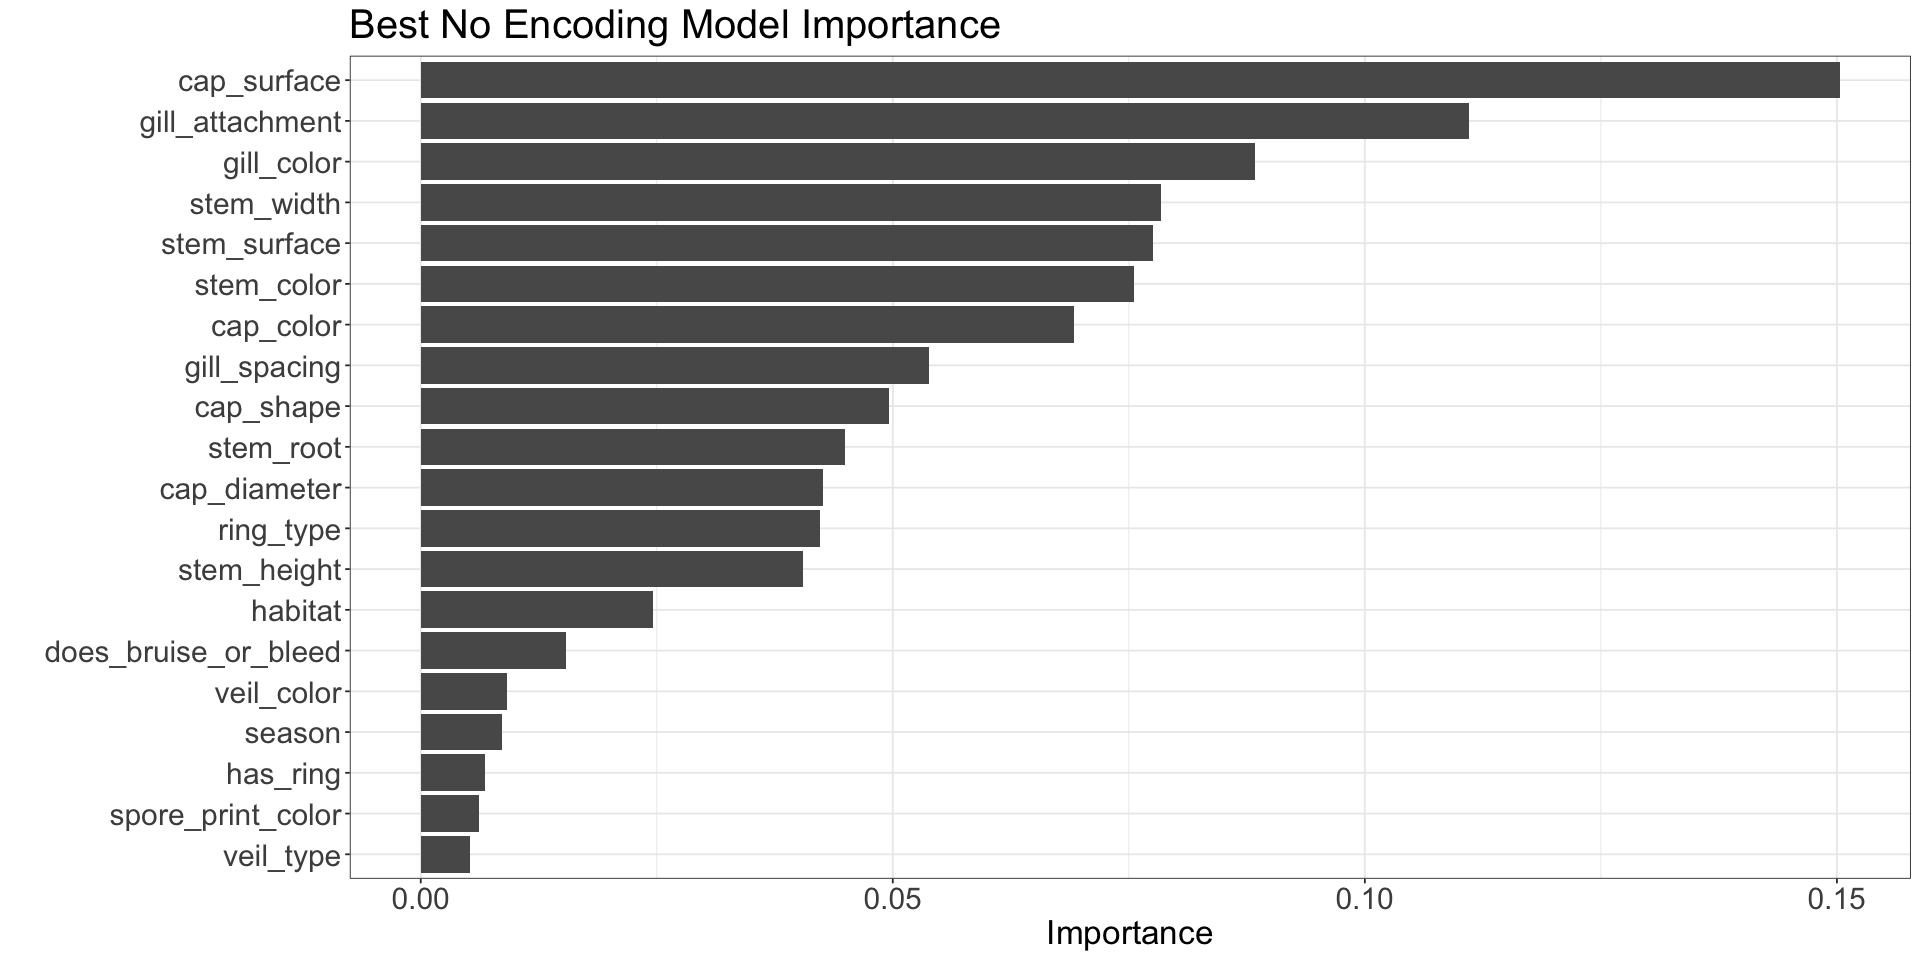

In [209]:
# Variable Importance of best model no encoding 
options(repr.plot.width=16, repr.plot.height=8)
vip_no_encoding <- best_no_encoding_model %>%
  extract_fit_engine() %>%
  vip(num_features = 22)
vip_no_encoding + ggtitle("Best No Encoding Model Importance") + my_theme()

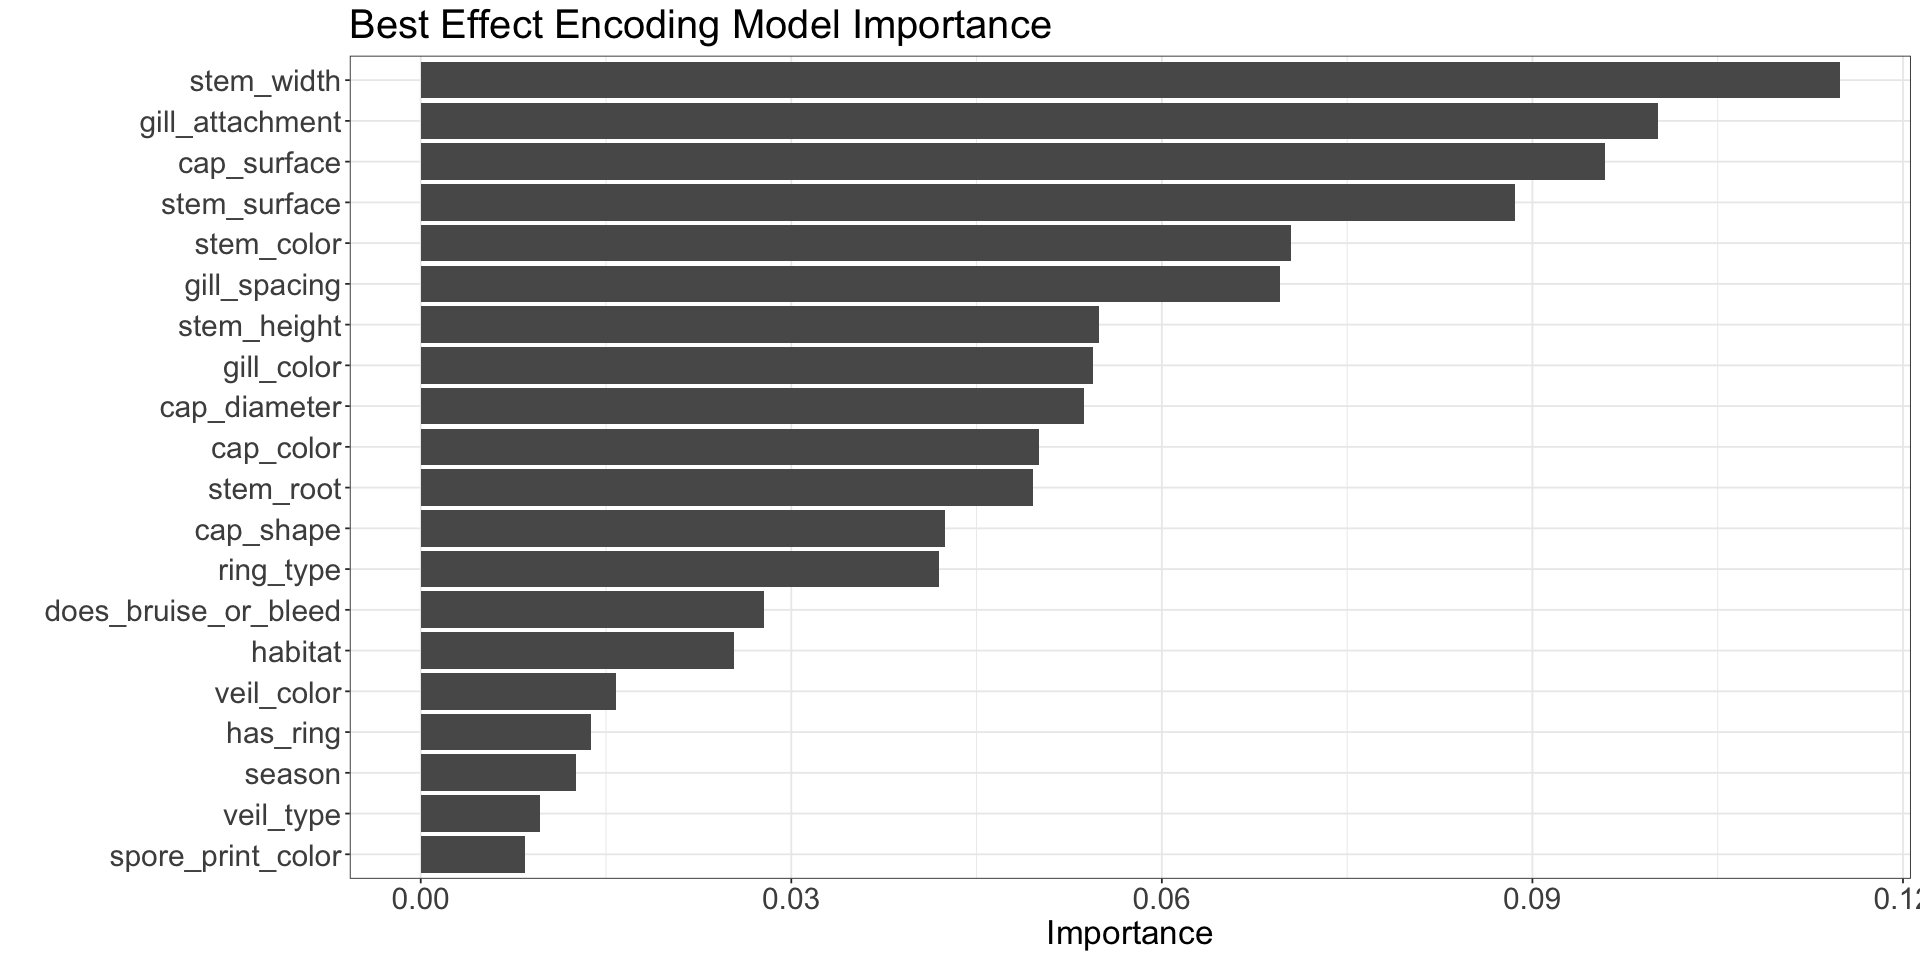

In [208]:
# Variable Importance of best model effect encoding 
vip_no_encoding <- best_eff_encoding_model %>%
  extract_fit_engine() %>%
  vip(num_features = 22)
vip_no_encoding + ggtitle("Best Effect Encoding Model Importance") + my_theme()

# **Submission**

In [213]:
test_out <- test_ready %>% 
  bind_cols("no_encode_preds" = predict(best_no_encoding_model, test_ready, type = "prob")$.pred_1) %>% 
  bind_cols("eff_encode_preds" = predict(best_eff_encoding_model, test_ready, type = "prob")$.pred_1) %>% 
  mutate(no_encode_class = if_else(no_encode_preds >= 0.46, 1, 0),
        eff_encode_class = if_else(eff_encode_preds >= 0.46, 1, 0)) %>% 
  select(id, no_encode_preds, eff_encode_preds, no_encode_class, eff_encode_class)
test_out %>% head(10)

id,no_encode_preds,eff_encode_preds,no_encode_class,eff_encode_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3116945,0.0017276623,0.0013848232,0,0
3116946,0.9988398428,0.9994197059,1,1
3116947,0.9912821088,0.9923352980,1,1
3116948,0.9948634152,0.9941926836,1,1
3116949,0.0010530994,0.0014651647,0,0
3116950,0.0079683115,0.0071022097,0,0
3116951,0.0023054898,0.0028096434,0,0
3116952,0.9985818442,0.9992973701,1,1
3116953,0.9967441715,0.9961659825,1,1


In [226]:
test_out %>% 
  select(id, no_encode_class) %>% 
  rename(class = no_encode_class) %>% 
  mutate(class = as.character(if_else(class == 1, "p", "e"))) %>%
  write_csv("Data/1_submission_rare_noencoded_lgbm_tuned_R.csv")

In [224]:
test_out %>% 
  select(id, eff_encode_class) %>% 
  rename(class = eff_encode_class) %>% 
  mutate(class = as.character(if_else(class == 1, "p", "e"))) %>%
  write_csv("Data/1_submission_rare_effect_encoded_lgbm_tuned_R.csv")

# **Saving relevant objects**

In [231]:
# Saving workflows that produced models:
relevant_objects <- list(
  tuned_workflows = tuned_workflows,
  best_no_encoding_model = best_no_encoding_model,
  best_eff_encoding_model = best_eff_encoding_model
)
saveRDS(relevant_objects, "Data/1_initial_models_submission.rds")


ERROR: Error in save_rds(relevant_objects, "Data/1_initial_models_submission.rds"): no se pudo encontrar la funci'on "save_rds"


In [13]:
write_csv(train_data, "Data/1_train_imputed_clean.csv")
write_csv(test_data, "Data/1_test_imputed_clean.csv")